In [2]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

#  차트 설정
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True

In [16]:
# 가격데이터
start_date = '20231201'
end_date = '20231205'
df = fdr.DataReader('005930', start_date)
# df = fdr.DataReader('005930', start_date, end_date)
df.head(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-12-01,72400,72500,71700,72000,9871284,-0.010989
2023-12-04,72800,72900,72400,72600,10229267,0.008333
2023-12-05,72300,72400,71200,71200,12129682,-0.019284
2023-12-06,71800,72100,71600,71900,4267970,0.009831


In [12]:
def get_KRX_list():
    kospi = fdr.StockListing('KOSPI')
    kosdaq = fdr.StockListing('KOSDAQ')
    kospi_list = kospi[['Code', 'Name']]
    kosdaq_list = kosdaq[['Code', 'Name']]
    data_list = pd.concat([kospi_list, kosdaq_list], axis=0)
    return data_list


def get_dataset(stock_code, stock_name, start_date, end_date):
    stock_df = fdr.DataReader(stock_code, start_date, end_date).reset_index()
    # stock_df['Name'] = stock_name
    stock_df.insert(0, 'Name', [f'{stock_name}']*stock_df.shape[0])
    return stock_df


start_date, end_date = '20231101', '20231108'
kospi = fdr.StockListing('KOSPI')[:50]
kospi_list = kospi[['Code', 'Name']]

all_stocks = pd.DataFrame()
for code, name in zip(kospi_list['Name'], kospi_list['Code']):
    stock = get_dataset(name, code, start_date, end_date)
    all_stocks = pd.concat([all_stocks, stock], ignore_index=True)

# 데이터 계층화를 위한 Date를 index로 작업
all_stocks.set_index(['Date'], inplace=True)
all_stocks.index.name = None

print(all_stocks.info())
print(all_stocks)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294 entries, 2023-11-01 to 2023-11-08
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    294 non-null    object 
 1   Open    294 non-null    int64  
 2   High    294 non-null    int64  
 3   Low     294 non-null    int64  
 4   Close   294 non-null    int64  
 5   Volume  294 non-null    int64  
 6   Change  294 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 18.4+ KB
None
             Name   Open   High    Low  Close    Volume    Change
2023-11-01   삼성전자  67500  68900  67300  68600  13775256  0.025411
2023-11-02   삼성전자  70000  70000  69400  69700  16350031  0.016035
2023-11-03   삼성전자  69700  70200  69500  69600  10322234 -0.001435
2023-11-06   삼성전자  69800  70900  69300  70900  22228489  0.018678
2023-11-07   삼성전자  70600  70900  70000  70900  17228731  0.000000
...           ...    ...    ...    ...    ...       ...       ...
2023-11-02  삼성

              Mean       Std
Name                        
HD한국조선해양  0.001213  0.003153
HD현대중공업   0.001330  0.002966
HMM       0.002060  0.006314
KB금융      0.000292  0.004156
KT       -0.000350  0.001161
KT&G      0.000161  0.001487
LG        0.000896  0.003188
LG에너지솔루션  0.002317  0.008756
LG전자      0.000429  0.001934
LG화학      0.001600  0.004883
NAVER     0.000831  0.002488
POSCO홀딩스  0.001970  0.008196
S-Oil     0.000243  0.001779
SK        0.001654  0.001797
SK바이오팜    0.002612  0.002379
SK이노베이션   0.002463  0.006952
SK텔레콤    -0.000303  0.000997
SK하이닉스    0.001009  0.002992
고려아연      0.000991  0.001694
기아       -0.000091  0.001442
기업은행      0.000322  0.001469
대한항공      0.000591  0.001881
두산에너빌리티   0.001639  0.003937
메리츠금융지주   0.000569  0.000494
삼성SDI     0.000876  0.005753
삼성물산      0.000855  0.000811
삼성바이오로직스  0.000641  0.001342
삼성생명     -0.001091  0.001307
삼성에스디에스   0.000447  0.001505
삼성전기      0.000628  0.002605
삼성전자      0.000338  0.001210
삼성전자우     0.000487  0.000763
삼성중공업     0.00

Text(0, 0.5, 'Std')

c:\Users\Minnie\anaconda3\envs\ai2\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\Minnie\anaconda3\envs\ai2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


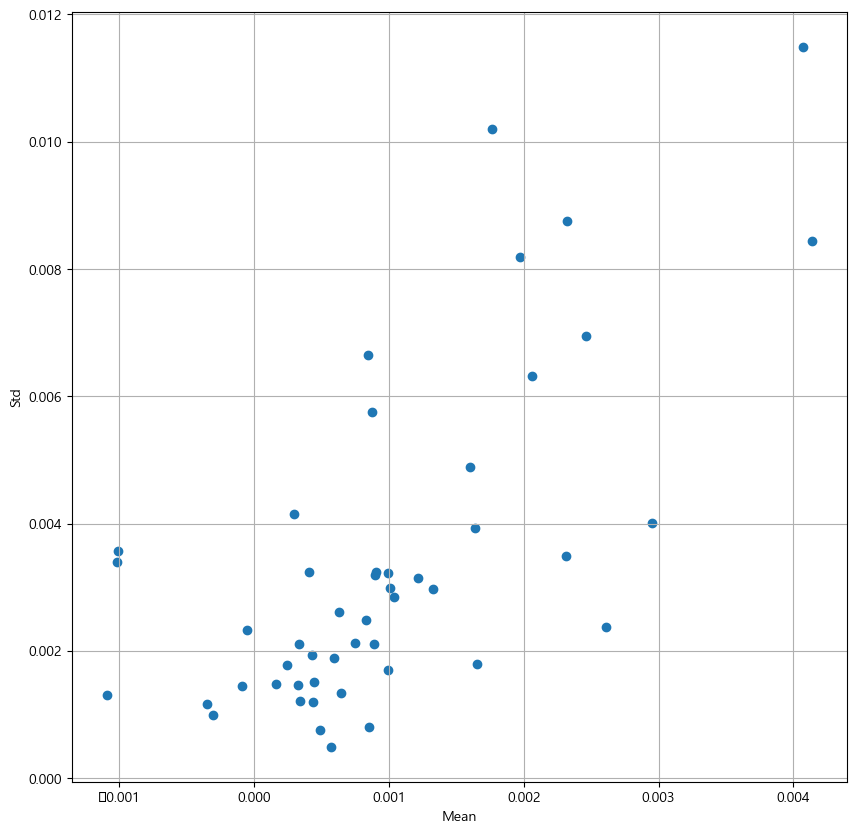

In [121]:
# 종가 데이터의 로그, 차분
close_prices = all_stocks[['Name', 'Close']].copy()

close_prices['Close'] = np.log(close_prices['Close'])
x = close_prices.groupby('Name').pct_change()
x['Name']=close_prices['Name']
x_mean = x.groupby('Name').mean()
x_std = x.groupby('Name').std()
result_df = pd.DataFrame({
    'Mean': x_mean['Close'],
    'Std': x_std['Close']
})

# print(result_df)
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(result_df['Mean'], result_df['Std'])
plt.xlabel('Mean')
plt.ylabel('Std')

In [177]:
close_prices = all_stocks[['Name', 'Close']].copy()
# close_prices['Close'] = np.log(close_prices['Close'])
x = close_prices.groupby('Name').pct_change()
x['Name']=close_prices['Name']
x_mean = x.groupby('Name').mean() 
x_std = x.groupby('Name').std() 
result_df = pd.DataFrame({
    'Returns': x_mean['Close'],
    'Volatility': x_std['Close']
})
result_df

,Returns,Volatility
Name,,
HD한국조선해양,0.014486,0.036848
HD현대중공업,0.015947,0.034785
HMM,0.021441,0.062694
KB금융,0.003919,0.045154
KT,-0.003583,0.011982
KT&G,0.001943,0.017008
LG,0.010644,0.036879
LG에너지솔루션,0.035354,0.120704
LG전자,0.005137,0.022545


In [222]:
cosine_sim = cosine_similarity(result_df)
df = pd.DataFrame(cosine_sim, index=result_df.index, columns=result_df.index)
df=df.iloc[0]
max_df = df.sort_values(ascending=False)[1:].max()
df[df==max_df].index



Index(['포스코퓨처엠'], dtype='object', name='Name')

In [188]:
data = {name: [volatility] for name, volatility in zip(result_df.index, result_df['Volatility'])}
data
# df = pd.DataFrame(data)

# # 결측치 처리
# df = df.fillna(0)

# # 데이터 표준화
# scaler = StandardScaler()
# returns_scaled = scaler.fit_transform(df.T)

# # Cosine Similarity 계산
# cosine_sim = cosine_similarity(returns_scaled)
# cosine_sim

# # 결과 출력
# similar_pairs = []
# for i in range(len(cosine_sim)):
#     for j in range(i + 1, len(cosine_sim)):
#         similar_pairs.append(((df.columns[i], df.columns[j]), cosine_sim[i, j]))

# similar_pairs.sort(key=lambda x: x[1], reverse=True)

# print("All similar pairs:")
# for pair, similarity in similar_pairs:
#     print(f"{pair[0]} and {pair[1]}: {similarity}")

{'HD한국조선해양': [0.036847787953637925],
 'HD현대중공업': [0.03478515662257837],
 'HMM': [0.06269386136743645],
 'KB금융': [0.0451544178913985],
 'KT': [0.011981797777063152],
 'KT&G': [0.01700789216354305],
 'LG': [0.036879366166004277],
 'LG에너지솔루션': [0.12070399928035122],
 'LG전자': [0.022545102726222958],
 'LG화학': [0.06522404131779841],
 'NAVER': [0.03065541742441584],
 'POSCO홀딩스': [0.11079990768523316],
 'S-Oil': [0.019868997531814227],
 'SK': [0.02181208419164171],
 'SK바이오팜': [0.027880256240593877],
 'SK이노베이션': [0.08438855661919054],
 'SK텔레콤': [0.01072629167282492],
 'SK하이닉스': [0.0357047161221245],
 '고려아연': [0.02258604202615349],
 '기아': [0.01625366045901044],
 '기업은행': [0.013819199135387315],
 '대한항공': [0.018879171937741034],
 '두산에너빌리티': [0.0385048000916211],
 '메리츠금융지주': [0.0053968663427976776],
 '삼성SDI': [0.07626446145575948],
 '삼성물산': [0.009516321161886391],
 '삼성바이오로직스': [0.018354370857279912],
 '삼성생명': [0.014358989286594714],
 '삼성에스디에스': [0.018002948995511078],
 '삼성전기': [0.030897677612180298]

In [53]:
# 코사인 유사도 + K-Means 클러스터링
def cosine_kmeans_clustering(data, n_clusters):
    similarity_matrix = cosine_similarity(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(similarity_matrix)
    return labels

# PCA + K-Means 클러스터링
def pca_kmeans_clustering(data, n_clusters):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(reduced_data)
    return labels

def add_cluster_labels(df, labels):
    df['Cluster'] = labels
    return df

In [81]:
numeric_data = mean_x[['Close']]
cosine_labels = cosine_kmeans_clustering(numeric_data, n_clusters=3)
df_cosine_clusters = add_cluster_labels(numeric_data.copy(), cosine_labels).sort_values(by='Cluster')
df_cosine_clusters

c:\Users\Minnie\anaconda3\envs\ai2\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Minnie\anaconda3\envs\ai2\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


,Close,Cluster
Name,,
하이브,-0.001012,1
KT,-0.000350,1
기아,-0.000091,1
SK텔레콤,-0.000303,1
삼성화재,-0.001016,1
삼성생명,-0.001091,1
신한지주,-0.000053,1
HD한국조선해양,0.001213,2
삼성에스디에스,0.000447,2


C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\ProgramData\anaconda3\envs\transformer\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


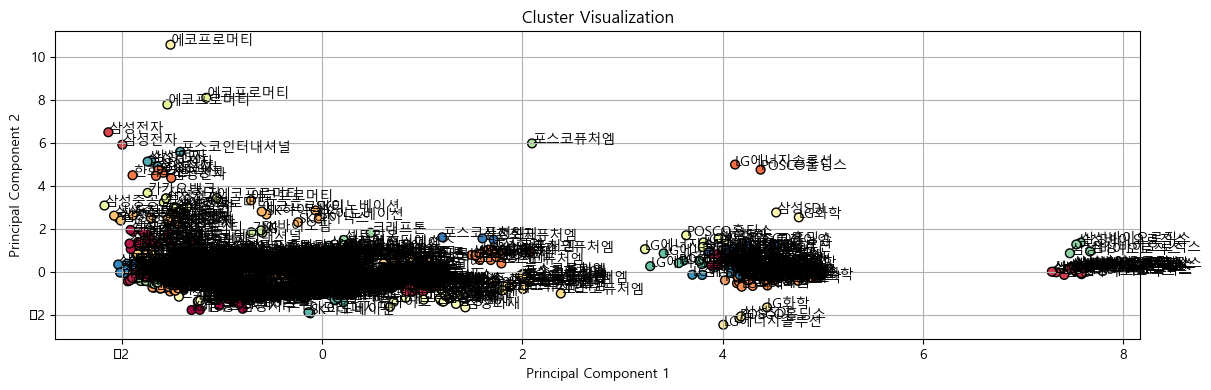

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [82]:
df = all_stocks
df.dropna(axis=0, inplace=True)

# StandardScaler를 사용하여 데이터 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

# PCA로 차원 축소
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# K-Means 클러스터링
kmeans = KMeans(n_clusters=len(df['Name'].unique()), random_state=42)
labels = kmeans.fit_predict(reduced_data)

# 클러스터링 결과 시각화
df['Cluster'] = labels
colors = plt.cm.Spectral(df['Cluster'].astype(float) / len(df['Cluster'].unique()))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, edgecolor='k', s=40)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 각 점에 회사명 표시
for company, x, y in zip(df['Name'], reduced_data[:, 0], reduced_data[:, 1]):
    plt.text(x, y, company)

plt.show()
print(set(labels))

In [ ]:
# sample
start_date = '20231201'
end_date = '20231205'
code = '005930'
name = '삼성전자'
df = get_dataset(code, name, start_date, end_date)
print(df)

In [ ]:
# 종가 데이터 

start_date = '20231201'
end_date = '20231205'
data_list = pd.DataFrame({
    'Code': ['005930', '373220', '000660'],
    'Name': ['삼성전자', 'LG에너지솔루션', 'SK하이닉스']
})


print(data_list.shape)
# data_list.columns = ['Code', 'Name']
# 한국거래소 상장종목 전체 조회
# kospi = fdr.StockListing('KOSPI')
# kosdaq = fdr.StockListing('KOSDAQ')

# kospi_list = kospi[['Code', 'Name']]
# kosdaq_list = kosdaq[['Code', 'Name']]
# data_list = pd.concat([kospi_list, kosdaq_list], axis=0)

# kospi_list 종가 차트
df = fdr.DataReader('005930', start_date, end_date)

print(df.columns)

In [ ]:
start_date = '20231101'
end_date = '20231130'
kospi = fdr.StockListing('KOSPI')
kospi_list = kospi[['Code', 'Name']][:10]

all_stocks = pd.DataFrame()
for code, name in zip(kospi_list['Name'], kospi_list['Code']):
    stock = get_dataset(name, code, start_date, end_date)
    stock = add_technical_indicators(stock)
    all_stocks = pd.concat([all_stocks, stock], ignore_index=True)
    
print(all_stocks)

In [ ]:
def get_dataset(stock_code, stock_name, start_date, end_date):
    stock_df = fdr.DataReader(stock_code, start_date, end_date).reset_index()
    stock_df['Name'] = stock_name
    return stock_df
def add_technical_indicators(stock_df):
    ma = [5,20,60,120]
    for days in ma:
        stock_df['ma_'+str(days)] = stock_df['Close'].rolling(window = days).mean()
    H, L, C, V = stock_df['High'], stock_df['Low'], stock_df['Close'], stock_df['Volume']

    stock_df['RSI'] = ta.momentum.rsi(close=C, fillna=True)
    stock_df['MACD'] = ta.trend.macd(close=C, fillna=True)
    stock_df['-VI'] = ta.trend.vortex_indicator_neg(high=H, low=L, close=C, fillna=True)
    stock_df['+VI'] = ta.trend.vortex_indicator_pos(high=H, low=L, close=C, fillna=True)
    return stock_df

# # 샘플 데이터 생성
# start_date = '2023-11-01'
# end_date = '2023-12-05'
# kospi_list = pd.DataFrame({
#     'Code': ['005930', '373220', '000660'],
#     'Name': ['삼성전자', 'LG에너지솔루션', 'SK하이닉스']
# })
start_date = '20231101'
end_date = '20231130'
kospi = fdr.StockListing('KOSPI')
kospi_list = kospi[['Code', 'Name']][:20]

all_stocks = pd.DataFrame()

# 데이터 수집 및 기술적 지표 추가
for code, name in zip(kospi_list['Name'], kospi_list['Code']):
    stock = get_dataset(name, code, start_date, end_date)
    stock = add_technical_indicators(stock)
    all_stocks = pd.concat([all_stocks, stock], ignore_index=True)

# Pivot 데이터 구성
features = all_stocks.columns.drop(['Name', 'Date'])
pivot_stocks = all_stocks.pivot(index='Date', columns='Name', values=features)
pivot_stocks = pivot_stocks.interpolate()

# NaN 값을 0으로 대체
pivot_stocks = pivot_stocks.fillna(0)

# 데이터 정규화
scaler = StandardScaler()
pivot_stocks_scaled = scaler.fit_transform(pivot_stocks)

# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=2)
pivot_stocks_pca = pca.fit_transform(pivot_stocks_scaled)

# DBSCAN을 사용한 클러스터링
dbscan = DBSCAN(eps=0.5, min_samples=2)
labels = dbscan.fit_predict(pivot_stocks_pca)

print(labels)
# # 종목별 클러스터 결과 저장
# all_stocks['Cluster'] = labels

# # 종목별 클러스터링 결과 시각화
# for name, group in all_stocks.groupby('Name'):
#     plt.figure(figsize=(8, 5))
#     for cluster_label in set(group['Cluster']):
#         cluster_data = group[group['Cluster'] == cluster_label]
#         plt.scatter(cluster_data['Date'], cluster_data['Close'], label=f'Cluster {cluster_label}')

#     plt.title(f'Clustering Result for {name}')
#     plt.xlabel('Date')
#     plt.ylabel('Close Price')
#     plt.legend()
#     plt.show()


In [ ]:
start_date = '20231201'
end_date = '20231205'

all_stocks = pd.DataFrame()
stock = get_dataset('005930', '삼성전자',start_date, end_date)
stock = add_technical_indicators(stock)
stock1 = get_dataset('373220', 'LG에너지솔루션', start_date, end_date)
stock1 = add_technical_indicators(stock1)
all_stocks = pd.concat([all_stocks, stock], ignore_index=True)
all_stocks = pd.concat([all_stocks, stock1], ignore_index=True)

# for code, name in zip(data_list['Code'], data_list['Name']):
#     tmp = get_dataset(code, start_date, end_date)
#     tmp = add_technical_indicators(tmp)
features = all_stocks.columns.drop(['Name'])

# print(all_stocks.shape)
# print(all_stocks)

pivot_stocks = all_stocks.pivot(index='Date', columns='Name', values=features)
pivot_stocks = pivot_stocks.interpolate()
print(pivot_stocks)
# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_stocks)

# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN을 사용한 클러스터링
dbscan = DBSCAN(eps=0.5, min_samples=2)  # eps는 이웃을 결정하는 반경, min_samples는 클러스터가 될 최소 데이터 수
labels = dbscan.fit_predict(X_pca)

# 클러스터링 결과를 시각화
plt.figure(figsize=(10, 6))

for label in set(labels):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=f'Cluster {label}')

plt.title('DBSCAN Clustering of Stock Data with Technical Indicators')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



In [ ]:
import pandas as pd
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# 필요한 특징 선택
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'RSI', 'MACD', '-VI', '+VI']]

# 표준화 (Standardization)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# DTW 거리 계산 함수
def dtw_distance(series1, series2):
    distance, path = fastdtw(series1, series2, dist=euclidean)
    return distance

# DTW 거리 행렬 생성
dtw_matrix = pd.DataFrame(index=features.index, columns=features.index)
for i in features.index:
    for j in features.index:
        dtw_matrix.at[i, j] = dtw_distance(features_scaled[i], features_scaled[j])

# K-Means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(dtw_matrix)

# 클러스터링 결과 시각화
plt.scatter(features['Date'], features['Close'], c=df['Cluster'], cmap='viridis')
plt.title('Stock Clustering based on DTW Distance')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
df = get_dataset('005930', start_date, end_date)
print(df)
df = add_technical_indicators(df)
print(df)

In [ ]:
features = df.columns
print([*features])


In [ ]:
# 13개의 회사, 50일치 데이터
num_companies = 13
num_days = 50
num_features = 6

data = np.random.rand(num_companies, num_days, num_features)
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
companies = [f'Company_{i}' for i in range(num_companies)]

# 임의의 주가 패턴 추가
for i in range(num_companies):
    data[i, :, :] += np.linspace(0, i * 0.1, num_days).reshape(-1, 1)

df = pd.DataFrame(data.reshape(-1, num_features), columns=columns)
df['Company'] = [companies[i] for i in range(num_companies) for _ in range(num_days)]
df['Date'] = np.tile(pd.date_range(start='2022-01-01', periods=num_days), num_companies)

df_pivot = df.pivot(index='Company', columns='Date', values=columns)

print(df_pivot.shape)

In [ ]:
# Calculate average annual percentage return and volatilities over a theoretical one year period
days = df.shape[0]
returns = df.pct_change().mean() * days
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = df.pct_change().std() * np.sqrt(days)
data=returns
# format the data as a numpy array to feed into the K-Means algorithm
# data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T 

scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

In [ ]:
# 기술적 지표를 기반으로 정규화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


# DBSCAN for Time Series
dbscan = DBSCAN(metric='euclidean', eps=0.5, min_samples=5)
df['DBSCAN_Labels'] = dbscan.fit_predict(df_scaled)
